# Model for single mode squeezed vacuum and squeezed coherent state

We test the boson sampling operator (no training) 
on coherent states and squeezed states, and 
propagating in a random medium

nonlinearxwaves@gmail.com<br>
@version 28 january 2021<br>
@version 3 may 2023 <b>

In [1]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-03 19:09:18.603202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-03 19:09:18.603225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [3]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-03 19:10:49.082571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-03 19:10:49.082613: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-03 19:10:49.082646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


## Dimension

In [7]:
N = 4

In [8]:
n=np.floor_divide(N,2)

## Build vacuum by the Gaussian state

In [9]:
vacuum = ps.VacuumLayer(N)

2023-05-03 19:10:53.151714: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Squeezer for mode 0

In [17]:
r_np=0.8;
theta_np=np.pi/4;
squeezer=ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=0)

## Displacer for mode 1

Define the alpha vector for the alpha

In [18]:
alpha=np.zeros([2],dtype=np_complex)

In [19]:
alpha[0]=0
alpha[1]=1.5
print(alpha)
print(np.abs(alpha)**2)

[0. +0.j 1.5+0.j]
[0.   2.25]


Define the corresponding displacement vector

In [20]:
dinput_np=np.zeros([N,1], dtype=np_real)
for j in range(n):
    dinput_np[2*j]=np.sqrt(2)*np.real(alpha[j])
    dinput_np[2*j+1]=np.sqrt(2)*np.imag(alpha[j])

In [21]:
dinput = tf.constant( dinput_np, dtype=vacuum.dtype)
displacer = ps.DisplacementLayerConstant(dinput)

## Random medium (non trainable)

In [22]:
R=ps.RandomLayerConstant(N)

## Build the model

In [23]:
xin = tf.keras.layers.Input(N)
x1, a1 = R(xin)
x2, a2 = displacer(x1, a1)
x3, a3 = squeezer(x2, a2)
chir, chii = vacuum(x3, a3)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [24]:
cov_layer = ps.CovarianceLayer(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0.18 2.06 0.45 0.09]], shape=(1, 4), dtype=float32)
[[1.08352721 -0.108666956 0.367201269 0.504930854]
 [-0.108666897 1.06152725 -0.128855109 -0.554052293]
 [0.367201269 -0.128855109 1.08999693 1.77038634]
 [0.504930794 -0.554052353 1.7703861 3.9198761]]


# Evaluate the Qtransform with calculated covariance and displacemente

In [25]:
Qrho = ps.QTransform(cov0, d0)

# Test the Pr operator 

Probability of zero photon

In [26]:
%%time
ps.Pr([0,0], Qrho)

CPU times: user 5.24 ms, sys: 4.25 ms, total: 9.49 ms
Wall time: 8.05 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.08]], dtype=float32)>

Probability of two photons

In [28]:
%%time
ps.Pr([0,2], Qrho)

CPU times: user 106 ms, sys: 3.46 ms, total: 109 ms
Wall time: 108 ms


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01], dtype=float32)>

## Some numerical examples

In [29]:
%%time
nbar=[0,0]
tf.print(ps.Pr(nbar, Qrho))

[[0.0788069218]]
CPU times: user 14.8 ms, sys: 3.33 ms, total: 18.1 ms
Wall time: 15.8 ms


In [30]:
%%time
nbar=[1,0]
tf.print(ps.Pr(nbar, Qrho))

[0.169163257]
CPU times: user 18.1 ms, sys: 0 ns, total: 18.1 ms
Wall time: 17.2 ms


In [31]:
%%time
nbar=[1,1]
tf.print(ps.Pr(nbar, Qrho))

[0.0217944607]
CPU times: user 99.8 ms, sys: 6.21 ms, total: 106 ms
Wall time: 105 ms


In [32]:
%%time
nbar=[2,3]
tf.print(ps.Pr(nbar, Qrho))

[0.0159540363]
CPU times: user 19.4 s, sys: 79 ms, total: 19.4 s
Wall time: 19.4 s


## Make a plot versus the probability

Build an array of photon number sampling

In [33]:
%%time
nmax=3 # max number of photons
# generate the combinations
import itertools as it
nlist=it.product(range(nmax+1),repeat=n)
ln=list(nlist)
print(ln)
print(len(ln))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
16
CPU times: user 212 µs, sys: 11 µs, total: 223 µs
Wall time: 203 µs


In [34]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Computing Pn at n '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Computing Pn at n (0, 0)
0.07880692
Computing Pn at n (0, 1)
0.008152481
Computing Pn at n (0, 2)
0.014850222
Computing Pn at n (0, 3)
0.004778997
Computing Pn at n (1, 0)
0.16916326
Computing Pn at n (1, 1)
0.02179446
Computing Pn at n (1, 2)
0.025935082
Computing Pn at n (1, 3)
0.0120770885
Computing Pn at n (2, 0)
0.18021035
Computing Pn at n (2, 1)
0.030817911
Computing Pn at n (2, 2)
0.021221323
Computing Pn at n (2, 3)
0.015954036
Computing Pn at n (3, 0)
0.12717146
Computing Pn at n (3, 1)
0.029273344
Computing Pn at n (3, 2)
0.01074109
Computing Pn at n (3, 3)
0.014009271
Done
CPU times: user 4min 29s, sys: 1.27 s, total: 4min 30s
Wall time: 4min 31s


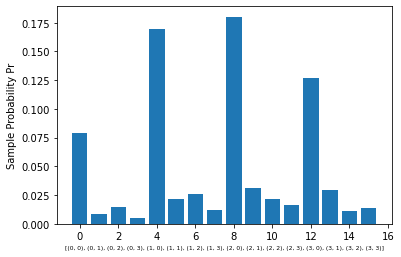

In [35]:
plt.bar(xaxis,Pn)
plt.xlabel(ln, fontsize=6);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample5.pdf', format='pdf', bbox_inches='tight')

Probability of the photon patterns
Sampling patters are indicate in the labels.